In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib

In [3]:
intakes  = "https://data.austintexas.gov/api/views/wter-evkm/rows.csv?accessType=DOWNLOAD"
outcomes = "https://data.austintexas.gov/api/views/9t4d-g238/rows.csv?accessType=DOWNLOAD"
df_intakes  = pd.read_csv(intakes)
df_outcomes = pd.read_csv(outcomes)

In [4]:
df_intakes.columns = df_intakes.columns.str.lower().str.replace(" ", "_")
df_intakes.columns

Index(['animal_id', 'name', 'datetime', 'monthyear', 'found_location',
       'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake',
       'age_upon_intake', 'breed', 'color'],
      dtype='object')

In [5]:
df_outcomes.columns = df_outcomes.columns.str.lower().str.replace(" ", "_")
df_outcomes.columns

Index(['animal_id', 'date_of_birth', 'name', 'datetime', 'monthyear',
       'outcome_type', 'outcome_subtype', 'animal_type', 'sex_upon_outcome',
       'age_upon_outcome', 'breed', 'color'],
      dtype='object')

In [6]:
# from outcomes selecting only the important columns 'animal_id', 'datetime','outcome_type' 
df_outcomes = df_outcomes[['animal_id', 'datetime', 'outcome_type']]

In [8]:
# merging the two dataframes on 'animal_id', just using the animals that are present in both dataframes as for the rest we dont have the outcome
df = pd.merge(df_intakes, df_outcomes, on='animal_id', how='inner', suffixes=('_intake', '_outcome'))
df = df.head(2000)
# df.head()
df.tail()

,animal_id,name,datetime_intake,monthyear,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type
1995,A666570,Willie,11/03/2013 10:22:00 PM,November 2013,9811 Blocker Ln in Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Pit Bull Mix,Brown/White,2013-11-07T16:53:00,Return to Owner
1996,A666570,Willie,11/03/2013 10:22:00 PM,November 2013,9811 Blocker Ln in Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Pit Bull Mix,Brown/White,2013-11-24T14:36:00,Return to Owner
1997,A616444,Springdale,11/04/2013 10:54:00 AM,November 2013,Tillary And Lyons in Austin (TX),Stray,Normal,Dog,Neutered Male,3 years,Labrador Retriever Mix,Yellow,2013-11-04T15:48:00,Return to Owner
1998,A616444,Springdale,11/04/2013 10:54:00 AM,November 2013,Tillary And Lyons in Austin (TX),Stray,Normal,Dog,Neutered Male,3 years,Labrador Retriever Mix,Yellow,2013-11-12T18:12:00,Return to Owner
1999,A616444,Springdale,11/04/2013 10:54:00 AM,November 2013,Tillary And Lyons in Austin (TX),Stray,Normal,Dog,Neutered Male,3 years,Labrador Retriever Mix,Yellow,2013-11-27T15:20:00,Return to Owner


In [9]:
df.shape

(2000, 14)

In [10]:
animal_id_counts = df['animal_id'].value_counts()
animal_id_counts

animal_id
A665309    9
A658733    7
A641748    6
A665629    6
A664941    5
          ..
A666527    1
A666528    1
A666529    1
A666534    1
A661807    1
Name: count, Length: 1710, dtype: int64

In [11]:
# Create target column
df["adopted"] = (df["outcome_type"] == "Adoption").astype(int)

<Axes: xlabel='outcome_type'>

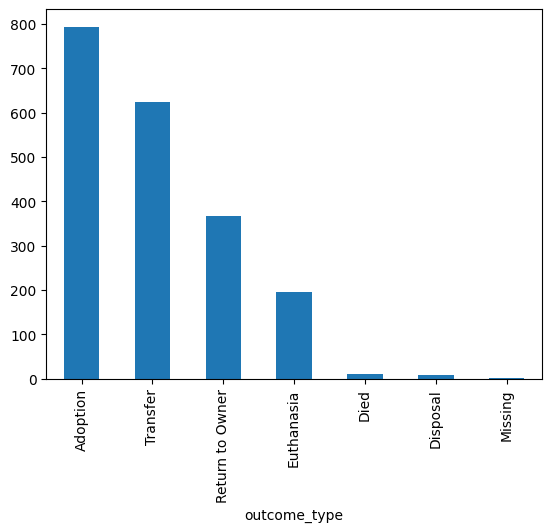

In [12]:
# animals by outcome_type in graph 
df['outcome_type'].value_counts().plot.bar()

In [13]:
# Fill missing values
df = df.fillna({
    "intake_type": "Unknown",
    "intake_condition": "Unknown",
    "sex_upon_intake": "Unknown",
    "monthyear": "Unknown"
})

In [14]:
df.dtypes


animal_id           object
name                object
datetime_intake     object
monthyear           object
found_location      object
intake_type         object
intake_condition    object
animal_type         object
sex_upon_intake     object
age_upon_intake     object
breed               object
color               object
datetime_outcome    object
outcome_type        object
adopted              int64
dtype: object

In [15]:
# Convert monthyear to numeric features
# ----------------------------
df["monthyear"] = pd.to_datetime(df["monthyear"], errors='coerce')
df["month"] = df["monthyear"].dt.month.fillna(0).astype(int)
df["year"] = df["monthyear"].dt.year.fillna(0).astype(int)

C:\Users\snigd\AppData\Local\Temp\ipykernel_18212\3885704529.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["monthyear"] = pd.to_datetime(df["monthyear"], errors='coerce')


In [16]:
# Encode categorical features
# ----------------------------
categorical_features = ["intake_type", "intake_condition", "animal_type",
                        "sex_upon_intake", "breed", "color"]

In [17]:
from sklearn.feature_extraction import DictVectorizer
# Copy dataframe
df_features = df.copy()

In [18]:
# Convert categorical columns to dict
cat_dicts = df_features[categorical_features].to_dict(orient='records')

In [19]:
# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

In [20]:
# Fit and transform
X_cat = dv.fit_transform(cat_dicts)

In [21]:
# X_cat is now a numeric array for categorical features
print(X_cat.shape)

(2000, 462)


In [22]:
# Optionally, combine with numeric columns
numeric_features = ["month", "year"]  # if you extracted month/year
X_numeric = df_features[numeric_features].values

In [23]:
import numpy as np
X = np.hstack([X_numeric, X_cat])
y = df["adopted"].values

In [24]:
# Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Train RandomForest
# ----------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
# Evaluate
# ----------------------------
y_pred = model.predict(X_test)
print("F1-score:", f1_score(y_test, y_pred))

F1-score: 0.41042345276872966


In [ ]:
pip install xgboost


In [30]:
# Models: Logistic Regression, Random Forest, XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


In [31]:
# Train the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric="logloss"
    )
}

results = {}
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1-score": f1_score(y_test, preds)
    }
    
    trained_models[name] = model

results


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


{'Logistic Regression': {'Accuracy': 0.5625,
  'Precision': 0.4435483870967742,
  'Recall': 0.3416149068322981,
  'F1-score': 0.38596491228070173},
 'Random Forest': {'Accuracy': 0.5525,
  'Precision': 0.4375,
  'Recall': 0.391304347826087,
  'F1-score': 0.4131147540983607},
 'XGBoost': {'Accuracy': 0.545,
  'Precision': 0.42758620689655175,
  'Recall': 0.38509316770186336,
  'F1-score': 0.40522875816993464}}

In [32]:
# Metrics Comparison
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.5625,0.443548,0.341615,0.385965
Random Forest,0.5525,0.437500,0.391304,0.413115
XGBoost,0.5450,0.427586,0.385093,0.405229


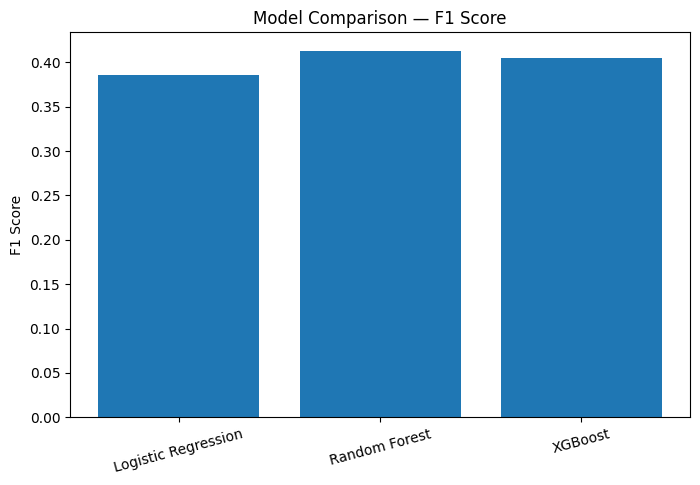

In [33]:
# Visualization: Bar Chart of F1-score
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df["F1-score"])
plt.xticks(rotation=15)
plt.title("Model Comparison — F1 Score")
plt.ylabel("F1 Score")
plt.show()


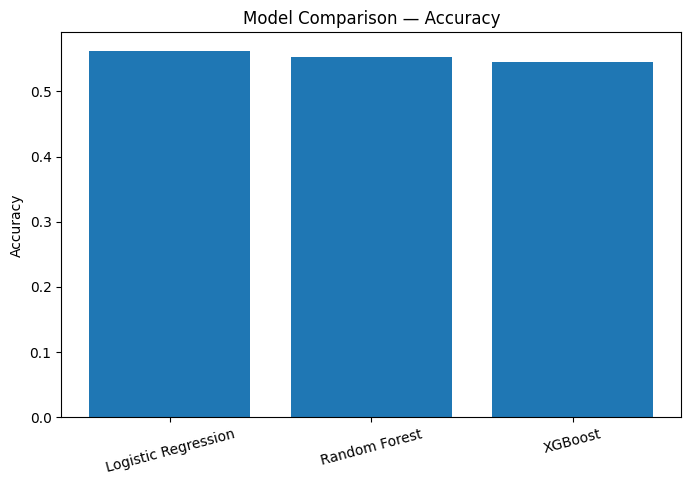

In [34]:
# Visualization: Accuracy Comparison
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df["Accuracy"])
plt.xticks(rotation=15)
plt.title("Model Comparison — Accuracy")
plt.ylabel("Accuracy")
plt.show()


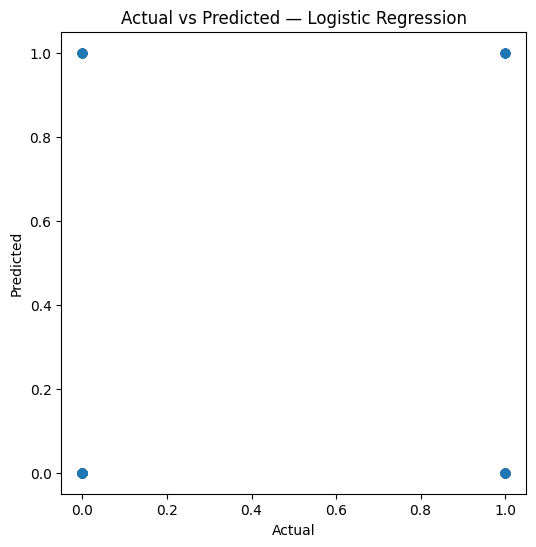

In [36]:
# Actual vs Predicted Plot for Best Model
best_model_name = results_df["F1-score"].idxmin()
best_model = trained_models[best_model_name]

preds_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds_best, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted — {best_model_name}")
plt.show()


In [27]:
# Save model and DictVectorizer
# ----------------------------
joblib.dump(model, "model.joblib")
joblib.dump(dv, "dictvectorizer.joblib")
print("Model and DictVectorizer saved successfully!")

Model and DictVectorizer saved successfully!
